In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV

df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df.head()

/home/daniil/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Name,Category,Brand,Seller,Deliveryscheme,Comments,Rating,Price,Max price,Min price,Average price,Days in stock,Sales
0,Сменный аэрозоль AirWick Дикий Гранат 250мл,Бытовая химия/Освежители и ароматизаторы/Арома...,AirWick,"ЕкомСистема, доставка OZON",FBS,0,"0,0000",489.0,549.0,329.0,489.000000,18.0,1.0
1,"Фигурка декоративная Pavone Ангел JP-05/ 6, 1...",Дом и сад/Декор и интерьер/Оформление интерьер...,Pavone,Art East,FBO,0,"0,0000",1631.0,1631.0,1631.0,1631.000000,4.0,1.0
2,Фенугрек/Пажитник молотый (Fenugreek (Methi) P...,"Продукты питания/Масла, соусы, специи/Специи и...",Золото Индии,"ООО ""Амрита"", доставка OZON",FBS,3,"5,0000",400.0,400.0,400.0,400.000000,22.0,13.0
3,Пазл Castorland 1000 деталей: Ожившая картина,Хобби и творчество/Пазлы и головоломки/Пазлы/C...,Castorland,"ShopUdachi.ru, доставка OZON",FBS,0,"0,0000",660.0,740.0,660.0,713.333333,8.0,3.0
4,"SIKU Самосвал Liebherr T 264, 1:87",Детские товары/Игрушки и игры/Игрушечный транс...,Siku,"Gnom.land, доставка OZON",FBS,0,"0,0000",2881.0,2881.0,2881.0,2881.000000,1.0,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751774 entries, 0 to 751773
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Name            751774 non-null  object 
 1   Category        751774 non-null  object 
 2   Brand           700066 non-null  object 
 3   Seller          751774 non-null  object 
 4   Deliveryscheme  751774 non-null  object 
 5   Comments        751774 non-null  int64  
 6   Rating          751774 non-null  object 
 7   Price           751774 non-null  float64
 8   Max price       751774 non-null  float64
 9   Min price       751774 non-null  float64
 10  Average price   683438 non-null  float64
 11  Days in stock   751774 non-null  object 
 12  Sales           751774 non-null  float64
dtypes: float64(5), int64(1), object(7)
memory usage: 74.6+ MB


In [4]:
df.describe()

,Comments,Price,Max price,Min price,Average price,Sales
count,751774.000000,7.517740e+05,7.517740e+05,7.517740e+05,6.834380e+05,751774.000000
mean,12.197287,3.352784e+03,3.439308e+03,3.243977e+03,3.232221e+03,21.514135
std,146.673229,6.022085e+04,6.025868e+04,5.990905e+04,5.949829e+04,99.855354
min,0.000000,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,0.000000,4.970000e+02,5.070000e+02,4.790000e+02,4.810000e+02,1.000000
50%,0.000000,1.031000e+03,1.073000e+03,9.970000e+02,9.990000e+02,3.000000
75%,1.000000,2.490000e+03,2.549000e+03,2.392000e+03,2.394000e+03,10.000000
max,20224.000000,3.442755e+07,3.442755e+07,3.442755e+07,3.442755e+07,4237.000000


## Количественные / Quantitative

In [5]:
df.Rating = df.Rating.str.replace(',', '.').astype(float)
df_test.Rating = df_test.Rating.str.replace(',', '.').astype(float)

In [6]:
df = df[~pd.to_numeric(df['Days in stock'], errors='coerce').isna()]
df_test = df_test[~pd.to_numeric(df_test['Days in stock'], errors='coerce').isna()]

df['Days in stock'] = df['Days in stock'].astype(float)
df_test['Days in stock'] = df_test['Days in stock'].astype(float)

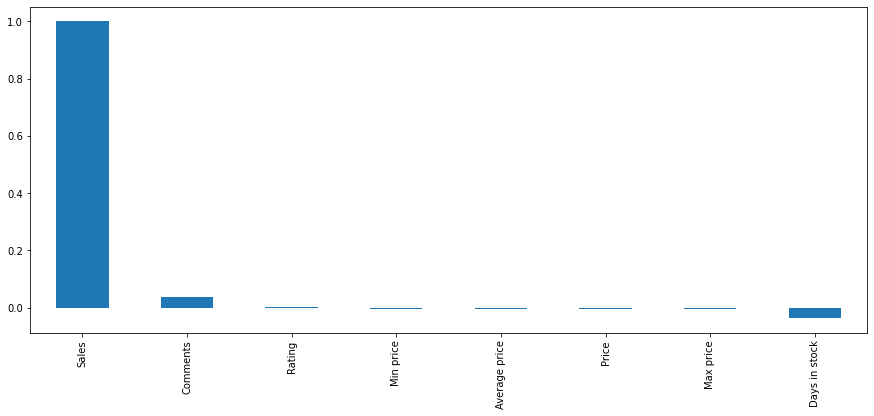

In [7]:
plt.figure(figsize=(15, 6))
bars = df.corr()['Sales'].sort_values(ascending=False).plot(kind='bar')

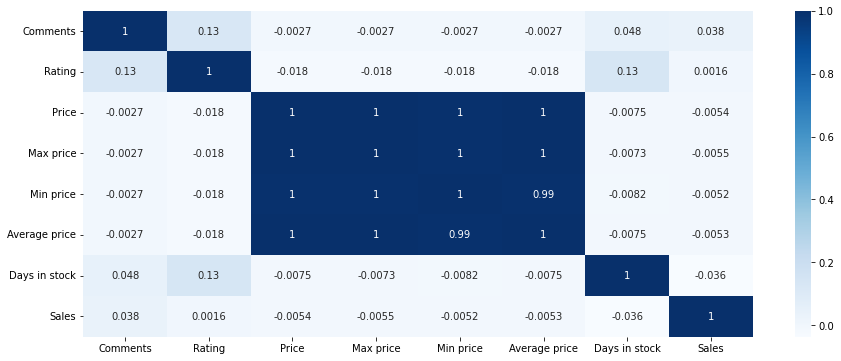

In [8]:
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(df.corr(), annot=True, cmap="Blues")

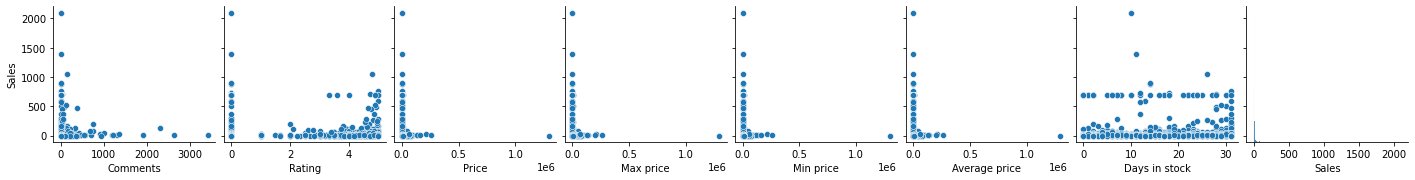

In [9]:
sns.pairplot(df.head(n=5000), y_vars=['Sales'], dropna=True)

In [10]:
df['Average price'].fillna((df['Max price'] + df['Min price']) / 2, inplace=True)

In [11]:
df = df.drop(columns=['Max price', 'Min price'])
df_test = df_test.drop(columns=['Max price', 'Min price'])

## Price

In [12]:
# Q1 = df['Price'].quantile(0.25)
# Q3 = df['Price'].quantile(0.75)
# IQR = Q3 - Q1
# whisker_width = 1.5
#
# index = df.index
# condition = (df['Price'] < Q1 - whisker_width*IQR) | (df['Price'] > Q3 + whisker_width*IQR)
# Price_outliers = index[condition]
#
# df = df.drop(Price_outliers).copy()
# df

## Категориальные / Category

In [13]:
df.select_dtypes('O').head()

,Name,Category,Brand,Seller,Deliveryscheme
0,Сменный аэрозоль AirWick Дикий Гранат 250мл,Бытовая химия/Освежители и ароматизаторы/Арома...,AirWick,"ЕкомСистема, доставка OZON",FBS
1,"Фигурка декоративная Pavone Ангел JP-05/ 6, 1...",Дом и сад/Декор и интерьер/Оформление интерьер...,Pavone,Art East,FBO
2,Фенугрек/Пажитник молотый (Fenugreek (Methi) P...,"Продукты питания/Масла, соусы, специи/Специи и...",Золото Индии,"ООО ""Амрита"", доставка OZON",FBS
3,Пазл Castorland 1000 деталей: Ожившая картина,Хобби и творчество/Пазлы и головоломки/Пазлы/C...,Castorland,"ShopUdachi.ru, доставка OZON",FBS
4,"SIKU Самосвал Liebherr T 264, 1:87",Детские товары/Игрушки и игры/Игрушечный транс...,Siku,"Gnom.land, доставка OZON",FBS


## Name

In [14]:
df.Name.nunique()
df = df.drop(['Name'], axis=1)
df_test = df_test.drop(['Name'], axis=1)

## Seller

In [15]:
def transform_seller(data):
    data = pd.concat([data, data.Seller.str.split(',', expand=True).iloc[:, 0:2]
                     .rename(columns={0: 'Seller_Org', 1: 'Seller_Info'})],
                     axis=1)
    data = data.drop(['Seller'], axis=1)
    return data

In [16]:
df = transform_seller(df)
df_test = transform_seller(df_test)

## Category

In [17]:
def transform_category(data):
    data = pd.concat([data, data.Category.str.split('/', expand=True).iloc[:, 0:5]
                     .rename(columns={0: 'C0', 1: 'C1', 2: "C2", 3: "C3", 4: "C4"})],
                     axis=1)
    data = data.drop(['Category'], axis=1)
    return data

In [18]:
df = transform_category(df)
df_test = transform_category(df_test)

In [19]:
def transform_brand(data):
    data.loc[df.groupby('Brand').Sales.transform('count') < 300, 'Brand'] = 'Rare'
    return data

df = transform_brand(df)

## Deliveryscheme

In [20]:
df.Deliveryscheme.nunique()

4

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 751771 entries, 0 to 751773
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Brand           700063 non-null  object 
 1   Deliveryscheme  751771 non-null  object 
 2   Comments        751771 non-null  int64  
 3   Rating          751771 non-null  float64
 4   Price           751771 non-null  float64
 5   Average price   751771 non-null  float64
 6   Days in stock   751771 non-null  float64
 7   Sales           751771 non-null  float64
 8   Seller_Org      751771 non-null  object 
 9   Seller_Info     487381 non-null  object 
 10  C0              751771 non-null  object 
 11  C1              750820 non-null  object 
 12  C2              742309 non-null  object 
 13  C3              677955 non-null  object 
 14  C4              390138 non-null  object 
dtypes: float64(5), int64(1), object(9)
memory usage: 91.8+ MB


## Подготовка данных

In [22]:
label = df['Sales']
df = df.drop(['Sales'], axis=1)

In [23]:
def split_features(data):
    cat_f = []
    nam_f = []
    for column in data.columns:
        if data[column].dtype.name == 'object':
            data[column] = data[column].fillna("None")
            data[column] = data[column].astype('category')
            cat_f.append(column)
        else:
            nam_f.append(column)
    return data[cat_f], data[nam_f]

In [24]:
df_cat, df_num = split_features(df)

In [25]:
df.nunique()

Brand               266
Deliveryscheme        4
Comments           1411
Rating              307
Price             24285
Average price     97555
Days in stock        32
Seller_Org        19176
Seller_Info          66
C0                   21
C1                  233
C2                 2183
C3                17971
C4                24420
dtype: int64

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


def scale_num(num_data):
    num_data_scaled = scaler.fit_transform(num_data)
    num_data_scaled = pd.DataFrame(num_data_scaled, index=num_data.index, columns=num_data.columns)
    return num_data_scaled

In [27]:
def preprocess_num_data(num_data):
    for column in num_data:
        num_data[column].fillna(np.nanmean(num_data[column]), inplace=True)
    num_data = scale_num(num_data)
    return num_data

In [28]:
df_num = preprocess_num_data(df_num)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [29]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 751771 entries, 0 to 751773
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Comments       751771 non-null  float64
 1   Rating         751771 non-null  float64
 2   Price          751771 non-null  float64
 3   Average price  751771 non-null  float64
 4   Days in stock  751771 non-null  float64
dtypes: float64(5)
memory usage: 34.4 MB


In [30]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 751771 entries, 0 to 751773
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   Brand           751771 non-null  category
 1   Deliveryscheme  751771 non-null  category
 2   Seller_Org      751771 non-null  category
 3   Seller_Info     751771 non-null  category
 4   C0              751771 non-null  category
 5   C1              751771 non-null  category
 6   C2              751771 non-null  category
 7   C3              751771 non-null  category
 8   C4              751771 non-null  category
dtypes: category(9)
memory usage: 18.6 MB


## Обучение

In [31]:
df = pd.concat([df_cat, df_num], axis=1)

In [32]:
df_data = lgb.Dataset(df, label=label)

In [33]:
df_test = df_test.drop(['Id'], axis=1)
df_test_cat, df_test_num = split_features(df_test)
df_test_num = preprocess_num_data(df_test_num)
df_test = pd.concat([df_test_cat, df_test_num], axis=1)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [34]:
params = {
    'lambda_l1': 0.9,
    'lambda_l2': 0.25,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'learning_rate': 0.01,
    'feature_fraction': 0.5,
    'bagging_fraction': 1,
    'bagging_freq': 1,
    'num_leaves': 47,
    'max_bin': 200,
    'num_threads': 2,
    'max_depth': 7,
    'verbose': -1,
    'num_iterations': 10000,
    #'early_stopping_rounds': 50
}

In [35]:
#X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.20)
#train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=df_cat.columns.tolist())
#test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=df_cat.columns.tolist())

#model = lgb.train(params, train_set=train_data, valid_sets=[train_data, test_data])

In [36]:
def plotImp(model, df, num=20, fig_size=(40, 20)):
    feature_imp = pd.DataFrame({'Value': model.feature_importance(), 'Feature': df.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale=5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


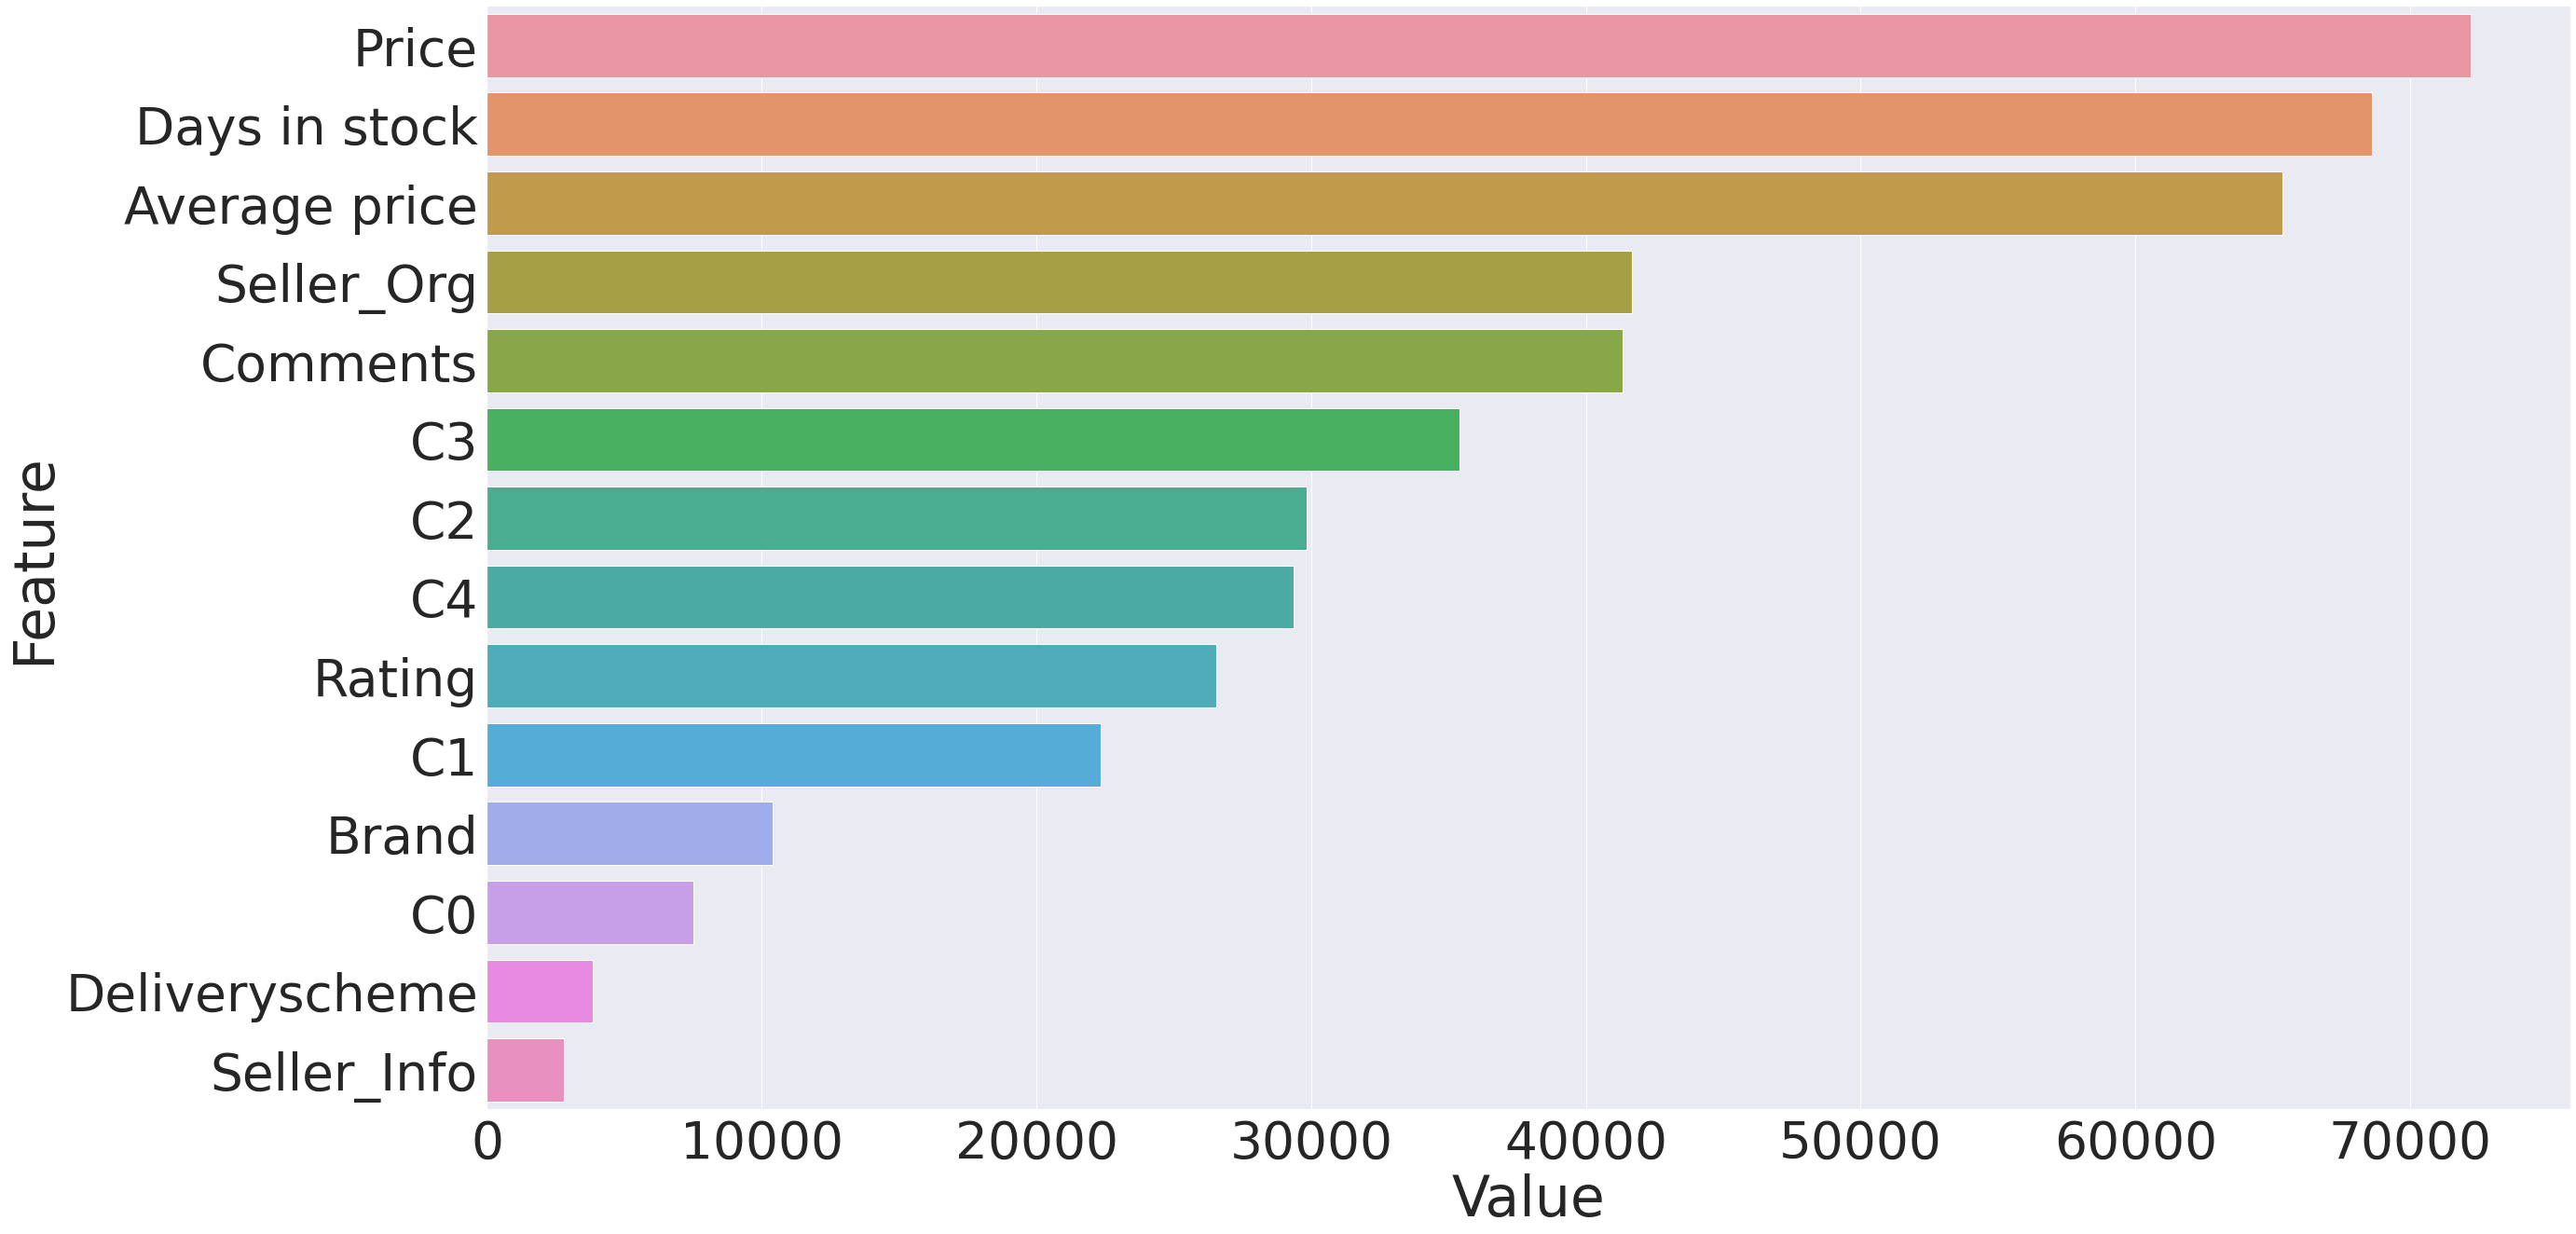

In [37]:
model = lgb.train(params, train_set=df_data)
plotImp(model, df)

In [38]:
y_pred_target = model.predict(df_test)

In [39]:
result = pd.DataFrame()
result['Expected'] = y_pred_target.astype(int)
result['Id'] = result.index
result.head()

,Expected,Id
0,5,0
1,10,1
2,288,2
3,-3,3
4,-1,4


In [40]:
result.Expected = result['Expected'].apply(lambda x: 0 if x < 0 else x)

In [41]:
result.to_csv('./submission.csv', index=False)